### Imports

In [1]:
import os, sys
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import random

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from time import time
from tensorflow.python.keras.callbacks import TensorBoard

from indicators import *
from data_loading import *
from util_functions import *


physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


### Parameters

In [2]:
trail_size=14
predict_length = 5
time_period = '4y'

### Load data

In [3]:
top100tech = ['AAPL', 'MSFT', 'TSM', 'NVDA', 'INTC', 'ASML', 'ADBE', 'CRM', 'AVGO', 'ORCL', 'CSCO', 'ACN', 'TXN', 'SHOP', 'QCOM', 'SAP', 'SNE', 'AMAT', 'INTU', 'NOW', 'SQ', 'IBM', 'MU', 'AMD',
'UBER', 'FIS', 'LRCX', 'FISV', 'SNOW', 'INFY', 'TEAM', 'ADSK', 'DELL', 'WDAY', 'VMW', 'ADI', 'NXPI', 'KLAC',
'CRWD', 'PLTR', 'DOCU', 'TEL', 'ERIC', 'MCHP', 'CDNS', 'CTSH', 'APH', 'SNPS', 'HPQ',
'PANW', 'OKTA','RNG','STM','MRVL','XLNX','WIT','MSI','SWKS','GLW','DDOG','ANSS','U','ZS','FTNT','STNE','ZBRA','KEYS','FTV','MXIM','COUP','GRMN','SPLK','HUBS','WORK','NET','FLT','CDW','CAJ','AFRM','PAYC','TER',
'VRSN','WDC', 'ZI', 'UMC','ANET','EPAM', 'UI','XM',
'GIB','TRMB', 'TYL','WIX','HPE','LYFT', 'LOGI', 'MPWR']
top10tech = top100tech[:10]

In [4]:
data = get_data_yf(top10tech, time_period)

[*********************100%***********************]  10 of 10 completed


In [5]:
data = process_stock_data_from_yf(data)

In [6]:
has_data_ratio, data = filter_has_all_data(data)

### Compute technical indicators

In [7]:
# compute all our technical markers for each of the stocks. 
dataset = data.groupby('Ticker').apply(lambda x: add_technical_markers(x, trail_size))

### Choose features

In [8]:
features = ['Close', 'High',
 'Low', 'Open', 'Volume', ]
#  'HH', 'LL', 'AV',
#  'SMA', 'SD', 'WILLR',
#  'ATR', 'DMH', 'DML',
#  'EMA', 'WMA', 'BBHIGH',
#  'BBLOW', 'PERBHIGH', 'PERBLOW',
#  'TRIMA', 'RSI', 'DX',
#  'PDI', 'NDI', 'ADX',
#  'ROC', 'MACD', 'CCI']
dataset = dataset[['Ticker', 'Date'] + features]
num_features = len(features)

### Normalization
We want to normalize the prices, and there are two challenges
1. We want to be able to recover performance metrics like RMSE in dollars, so we have to have the saved transforms for closing price to un transform after prediction. 
2. We will want to normalize the data within each year, because the stock will tend to have different averages in different years
3. We will want to normalize each different company differently, because the stocks will be of differing magnitudes

In [9]:
sc = RobustScaler()
dataset[features] = sc.fit_transform(dataset[features])

### Train test split

In [10]:
train = dataset.loc[dataset['Date'] < "2020-03-13"]
test = dataset.loc[dataset['Date'] > "2020-03-13"]

#### Prepare training inputs and outputs

In [11]:
x_train, y_train = roll_all_stocks(train, trail_size, predict_length)

In [12]:
x_test, y_test = roll_all_stocks(test, trail_size, predict_length)

#### Confirm shapes

In [13]:
print("x_train: {}".format(x_train.shape))
print("y_train: {}".format(y_train.shape))
print("x_test: {}".format(x_test.shape))
print("y_test {}".format(y_test.shape))

x_train: (7330, 14, 5)
y_train: (7330,)
x_test: (2370, 14, 5)
y_test (2370,)


### Model design

In [14]:
model = Sequential()
model.add(LSTM(units=75, input_shape=(trail_size, num_features), return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(units=30, return_sequences=True))
model.add(Dropout(0.25))

model.add(LSTM(units=30, return_sequences=True))
model.add(Dropout(0.25))

model.add(Flatten())
# model.add(Dense(50, activation='relu'))
# model.add(Dense(25, activation='relu'))
model.add(Dense(1))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 75)            24300     
_________________________________________________________________
dropout (Dropout)            (None, 14, 75)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 14, 30)            12720     
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 30)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 14, 30)            7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 30)            0         
_________________________________________________________________
flatten (Flatten)            (None, 420)               0

In [16]:
time_stamp = time()
tensorboard = TensorBoard(log_dir='logs/{}'.format(time_stamp))

In [17]:
model.compile(optimizer='adam', loss='mean_squared_error')

### Train on many stocks

In [18]:
history1 = model.fit(x_train, y_train, epochs=80, validation_data=(x_test, y_test), batch_size=64, shuffle=False, callbacks=[tensorboard])

Epoch 1/80
115/115 [==============================] - 8s 32ms/step - loss: 0.0819 - val_loss: 0.2297
Epoch 2/80
115/115 [==============================] - 1s 10ms/step - loss: 0.0221 - val_loss: 0.2407
Epoch 3/80
115/115 [==============================] - 1s 10ms/step - loss: 0.0159 - val_loss: 0.2124
Epoch 4/80
115/115 [==============================] - 1s 9ms/step - loss: 0.0135 - val_loss: 0.1817
Epoch 5/80
115/115 [==============================] - 1s 10ms/step - loss: 0.0123 - val_loss: 0.1622
Epoch 6/80
115/115 [==============================] - 1s 10ms/step - loss: 0.0118 - val_loss: 0.1829
Epoch 7/80
115/115 [==============================] - 1s 9ms/step - loss: 0.0109 - val_loss: 0.1475
Epoch 8/80
115/115 [==============================] - 1s 10ms/step - loss: 0.0104 - val_loss: 0.1068
Epoch 9/80
115/115 [==============================] - 1s 10ms/step - loss: 0.0130 - val_loss: 0.1413
Epoch 10/80
115/115 [==============================] - 1s 10ms/step - loss: 0.0108 - val_loss

### Prepare data for one stock

In [19]:
single_stock_dataset = dataset[dataset['Ticker']=='MSFT'].reset_index(drop=True)

### Train test split

In [20]:
train = single_stock_dataset.loc[single_stock_dataset['Date'] < "2020-03-13"]
test = single_stock_dataset.loc[single_stock_dataset['Date'] > "2020-03-13"]

#### Prepare training inputs and outputs

In [21]:
x_train, y_train = roll_all_stocks(train, trail_size, predict_length)

In [22]:
x_test, y_test = roll_all_stocks(test, trail_size, predict_length)

#### Confirm shapes

In [23]:
print("x_train: {}".format(x_train.shape))
print("y_train: {}".format(y_train.shape))
print("x_test: {}".format(x_test.shape))
print("y_test {}".format(y_test.shape)) 

x_train: (733, 14, 5)
y_train: (733,)
x_test: (237, 14, 5)
y_test (237,)


### Train model on single stock

In [25]:
tensorboard = TensorBoard(log_dir='logs/{}_2'.format(time_stamp))

In [26]:
history2 = model.fit(x_train, y_train, epochs=80, validation_data=(x_test, y_test), batch_size=64, shuffle=False, callbacks=[tensorboard])

Epoch 1/80
12/12 [==============================] - 2s 150ms/step - loss: 0.0010 - val_loss: 0.0026
Epoch 2/80
12/12 [==============================] - 0s 12ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 3/80
12/12 [==============================] - 0s 13ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 4/80
12/12 [==============================] - 0s 12ms/step - loss: 8.6938e-04 - val_loss: 0.0023
Epoch 5/80
12/12 [==============================] - 0s 12ms/step - loss: 8.6176e-04 - val_loss: 0.0024
Epoch 6/80
12/12 [==============================] - 0s 12ms/step - loss: 8.5983e-04 - val_loss: 0.0024
Epoch 7/80
12/12 [==============================] - 0s 12ms/step - loss: 7.6234e-04 - val_loss: 0.0023
Epoch 8/80
12/12 [==============================] - 0s 12ms/step - loss: 8.1320e-04 - val_loss: 0.0024
Epoch 9/80
12/12 [==============================] - 0s 12ms/step - loss: 7.7783e-04 - val_loss: 0.0025
Epoch 10/80
12/12 [==============================] - 0s 14ms/step - loss: 7.1584e-04

Epoch 80/80
12/12 [==============================] - 0s 12ms/step - loss: 6.7512e-04 - val_loss: 0.0087


### Visualize results

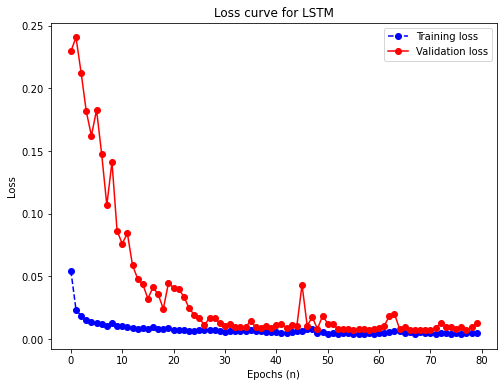

In [27]:
plot_loss(history1)

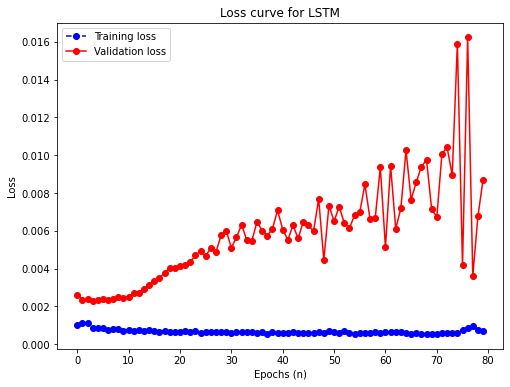

In [29]:
plot_loss(history2)

In [30]:
print("Training RMSE = {}".format(evaluate_model_rmse(model.predict(x_train), 
                                                      y_train,
                                                     num_features,
                                                     sc)))

Training RMSE = 3.3345976993825492


In [31]:
print("Testing RMSE = {}".format(evaluate_model_rmse(model.predict(x_test), 
                                                     y_test,
                                                    num_features,
                                                    sc)))

Testing RMSE = 15.740957211078946


#### Compare to simple baseline

In [32]:
def predict_no_change(x):
    return x[-1][0]

In [33]:
no_change_preds = np.array([predict_no_change(x) for x in x_train])
no_change_preds = np.expand_dims(no_change_preds, axis=1)

In [34]:
evaluate_model_rmse(no_change_preds, y_train, num_features, sc)

3.672158117675387

In [35]:
no_change_preds = np.array([predict_no_change(x) for x in x_test])
no_change_preds = np.expand_dims(no_change_preds, axis=1)

In [36]:
evaluate_model_rmse(no_change_preds, y_test, num_features, sc)

7.626194136851525